In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('yellow_tripdata_2018-01.csv', 
    nrows = 50000,
    parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
    dtype = 
         {'VendorID': 'uint8',
         'passenger_count': 'uint8',
         'trip_distance': 'float32',
         'RatecodeID': 'uint8',
         'PULocationID': 'uint16',
         'DOLocationID': 'uint16',
         'payment_type': 'uint8',
         'fare_amount': 'float32',
         'extra': 'float32',
         'mta_tax': 'float32',
         'tip_amount': 'float32',
         'tolls_amount': 'float32',
         'improvement_surcharge': 'float32',
         'total_amount': 'float32'}
     )
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y':1}).astype('bool')

In [2]:
df = df[(df['tpep_pickup_datetime'] >= '2018-01-01') & (df['tpep_pickup_datetime'] <= '2018-01-31')]
df = df[df['trip_distance']<100]

target = df['tip_amount']
#df = df[['payment_type', 'trip_distance', 'fare_amount']]

df = df.join(pd.get_dummies(df['payment_type'], prefix = 'payment_type')) 
df.drop(labels = ['payment_type', 'tip_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis = 1, inplace = True)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49806 entries, 0 to 49999
Data columns (total 17 columns):
VendorID                 49806 non-null uint8
passenger_count          49806 non-null uint8
trip_distance            49806 non-null float32
RatecodeID               49806 non-null uint8
store_and_fwd_flag       49806 non-null bool
PULocationID             49806 non-null uint16
DOLocationID             49806 non-null uint16
fare_amount              49806 non-null float32
extra                    49806 non-null float32
mta_tax                  49806 non-null float32
tolls_amount             49806 non-null float32
improvement_surcharge    49806 non-null float32
total_amount             49806 non-null float32
payment_type_1           49806 non-null uint8
payment_type_2           49806 non-null uint8
payment_type_3           49806 non-null uint8
payment_type_4           49806 non-null uint8
dtypes: bool(1), float32(7), uint16(2), uint8(7)
memory usage: 3.5 MB


In [3]:
df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,payment_type_1,payment_type_2,payment_type_3,payment_type_4
0,1,1,0.5,1,False,41,24,4.5,0.5,0.5,0.0,0.3,5.800000,0,1,0,0
1,1,1,2.7,1,False,239,140,14.0,0.5,0.5,0.0,0.3,15.300000,0,1,0,0
2,1,2,0.8,1,False,262,141,6.0,0.5,0.5,0.0,0.3,8.300000,1,0,0,0
3,1,1,10.2,1,False,140,257,33.5,0.5,0.5,0.0,0.3,34.799999,0,1,0,0
4,1,2,2.5,1,False,246,239,12.5,0.5,0.5,0.0,0.3,16.549999,1,0,0,0


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.3, random_state = 88)

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    max_depth = 4,
    n_estimators = 500,
    min_samples_split = 50,
    learning_rate = 0.01)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=50, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
from sklearn.metrics import mean_squared_error
y_train_hat = gbr.predict(X_train)
y_hat = gbr.predict(X_test)
print(mean_squared_error(y_train, y_train_hat))
print(mean_squared_error(y_test, y_hat))

0.6827235683209094
1.069079715908281


In [7]:
gbr_stop = GradientBoostingRegressor(
    max_depth = 4,
    n_estimators = 10000,
    min_samples_split = 50,
    learning_rate = 0.01,
    n_iter_no_change = 20)
gbr_stop.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=50, min_weight_fraction_leaf=0.0,
             n_estimators=10000, n_iter_no_change=20, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
#liczba estymatorów (drzew)
len(gbr_stop.estimators_)

4646

In [9]:
import matplotlib.pyplot as plt

Text(0,0.5,'Wartość funkcji straty')

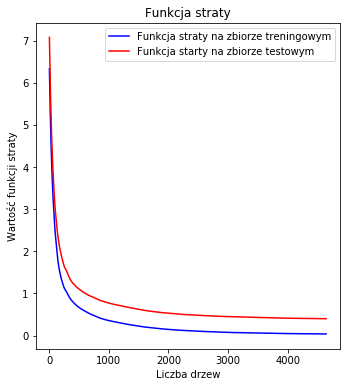

In [10]:
test_score = np.zeros(len(gbr_stop.train_score_), dtype=np.float64)

for i, y_pred in enumerate(gbr_stop.staged_predict(X_test)):
    test_score[i] =gbr_stop.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Funkcja straty')
plt.plot(np.arange(len(gbr_stop.train_score_)) + 1, gbr_stop.train_score_, 'b-',
         label='Funkcja straty na zbiorze treningowym')
plt.plot(np.arange(len(gbr_stop.train_score_)) + 1, test_score, 'r-',
         label='Funkcja starty na zbiorze testowym')
plt.legend(loc='upper right')
plt.xlabel('Liczba drzew')
plt.ylabel('Wartość funkcji straty')

In [11]:
y_train_stop_hat = gbr_stop.predict(X_train)
y_stop_hat = gbr_stop.predict(X_test)
print(mean_squared_error(y_train, y_train_stop_hat))
print(mean_squared_error(y_test, y_stop_hat))

0.06692352117546911
0.3996684178316139


In [12]:
from sklearn.model_selection import GridSearchCV

gbr_cv = GradientBoostingRegressor(
    n_estimators = 4500,
    learning_rate = 0.01)

siatka_parametrow_1 = {'max_depth': [3, 4, 5],
                     'max_features': [3, 5, 7],
                     'min_samples_split': [2, 50, 200]}
poszukiwanie_1 = GridSearchCV(gbr_cv, siatka_parametrow_1, cv = 5, n_jobs=-1, scoring='neg_mean_squared_error', return_train_score=True)
poszukiwanie_1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samp...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5], 'max_features': [3, 5, 7], 'min_samples_split': [2, 50, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [13]:
poszukiwanie_1.best_params_

{'max_depth': 5, 'max_features': 7, 'min_samples_split': 200}